# 0X01 Génération des parties

In [273]:
import numpy as np


In [274]:
coups = []
for i in range(1, 7):
    for j in range(i + 1, 7):
        coups.append({i, j})


In [275]:
class partie:
    def __init__(self):
        """
        生成单次对局
        """
        # Initialisation
        self.liste = [np.random.choice(range(15))]
        i = self.liste[-1]
        # La suite
        while i != 30:
            interdite = self.restriction(
                self.liste
            )  # Générer les coups interdite selon la règle
            possible = list(set(range(15)) - interdite)

            if possible != []:
                i = np.random.choice(possible)
            else:
                i = 30

            self.liste.append(i)
        self.liste.extend(list(np.zeros(16 - len(self.liste))))
        self.JI = self.liste[::2]
        self.JP = self.liste[1::2]

    def restriction(self, liste):
        """
        Donner les coups interdit selon les lignes déjà traitées(conservée dans liste)
        指出哪些线是不能画的
        """
        interdite = liste.copy()
        if len(liste) < 2:
            liste_self = []  # 自己划过的线
        else:
            liste_self = liste[::-1][1::2][::-1]  # 自己划过的线
        for i in liste_self:
            # 遍历自己已经画过的线
            points = set(range(1, 7))
            points = points - coups[i]
            for j in points:
                # 遍历和线i相连的其他线
                x, y = list(coups[i])
                m, n = list(set([x, j]))
                linenomx = -0.5 * m ** 2 + 5.5 * m + n - 7  # 顶点j对应的一根连线的编号
                m, n = list(set([y, j]))
                linenomy = -0.5 * m ** 2 + 5.5 * m + n - 7  # 另一根与j连线的编号
                if linenomx in liste_self:  # 如果相连的其他线也在liste_self中，那么就可以找到对应三角形的第三边
                    interdite.append(linenomy)
                elif linenomy in liste_self:
                    interdite.append(linenomx)
        return set(interdite)


In [276]:
partie().liste


[0, 4, 1, 14, 11, 10, 9, 12, 6, 8, 3, 2, 30, 0.0, 0.0, 0.0]

In [277]:
data = np.array([partie().liste for i in range(1000)]).astype(int)
data


array([[ 6,  0, 12, ..., 30,  0,  0],
       [ 1,  6, 13, ..., 30,  0,  0],
       [11, 14,  4, ...,  0,  0,  0],
       ...,
       [ 6, 14,  8, ...,  0,  0,  0],
       [ 0,  2, 13, ..., 30,  0,  0],
       [ 5,  9,  2, ...,  0, 30,  0]])

考虑把对局可视化的代码写一下

# 1x01 Première analyse 

In [278]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [279]:
pca = PCA(n_components=0.7)  # On se limite aux trois premiers axes
A1 = data.copy()
res1 = pca.fit(A1)


In [280]:
base = res1.components_  # 导出两个主特征向量

base[0][0::2], base[0][1::2]



(array([-0.00135569, -0.01562314, -0.00147731, -0.00124431, -0.00355021,
         0.00773584,  0.58250798,  0.05856374]),
 array([ 0.01546572, -0.01172308, -0.00181511, -0.00785959,  0.00471794,
         0.00665644, -0.81020022,  0.        ]))

尝试解读一下这些向量

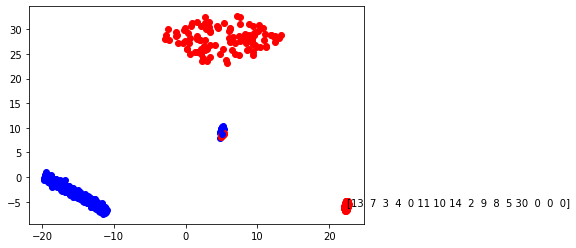

In [281]:
XX = res1.transform(A1)

n, p = A1.shape
for i in range(n):
    if (np.where(A1[i] == 30)[-1] % 2) == 0:
        plt.scatter(XX[i, 0], XX[i, 1], color="r")  # 红点先手胜
        if i == 23:
            # plt.text(0, 0,s=str(A1[i]))
            plt.text(XX[i, 0], XX[i, 1], s=str(A1[i]))  # 标出一个点的数据，分析一下
    else:
        plt.scatter(XX[i, 0], XX[i, 1], color="b")  # 蓝点后手胜


# 1x02 Analyse discriminante

In [282]:
A_Gagne = []
B_Gagne = []
gagneur = []

for i in range(n):
    if (np.where(A1[i] == 30)[0] % 2) == 0:
        A_Gagne.append(list(A1[i]))
        gagneur.append(2)
    else:
        B_Gagne.append(list(A1[i]))
        gagneur.append(1)
A_Gagne = np.array(A_Gagne)
B_Gagne = np.array(B_Gagne)


In [283]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda


In [284]:
my_lda = lda(n_components=1)  # 这里不让我n_components大于1（就是主平面只有1维），暂时不知道问题出在哪
res = my_lda.fit(data, gagneur)
X = res.transform(data)  # Une projection ? Laquelle ??



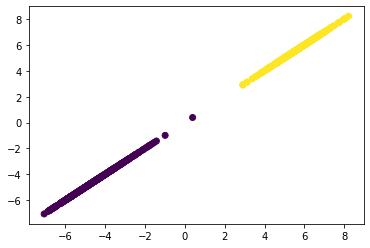

In [285]:
plt.scatter(X[:, 0], X[:, 0], c=gagneur)  # 右上先手胜，左下后手胜
# for i in range(len(a)):
#    plt.text(X[i, 0], X[i, 1], s=Noms[i])


# 2x01 Construction de fonction d'évaluation

# 2x02 实现min-max

In [286]:
def restriction(mes_coups, oppo_coups):
    liste = set.union(mes_coups, oppo_coups)
    interditeI = liste.copy()

    for i in mes_coups:
        # 遍历自己已经画过的线
        points = set(range(1, 7))
        points = points - coups[i]
        for j in points:
            # 遍历和线i相连的其他线
            x, y = list(coups[i])
            m, n = list(set([x, j]))
            linenomx = -0.5 * m ** 2 + 5.5 * m + n - 7  # 顶点j对应的一根连线的编号
            m, n = list(set([y, j]))
            linenomy = -0.5 * m ** 2 + 5.5 * m + n - 7  # 另一根与j连线的编号
            if linenomx in mes_coups:  # 如果相连的其他线也在self.JI中，那么就可以找到对应三角形的第三边
                interditeI.add(linenomy)
            elif linenomy in mes_coups:
                interditeI.add(linenomx)
    return set(range(15)) - interditeI


In [287]:
def minmax(coup, depth, maximizing=True):
    if depth == 0 or coup.isLeaf() == True:
        return coup.score
    coup.predict()
    if maximizing:
        maxEval = -np.infty
        for child in coup.children:
            eval = minmax(child, depth - 1, False)
            maxEval = max(maxEval, eval)
        return maxEval
    else:
        minEval = np.infty
        for child in coup.children:
            eval = minmax(child, depth - 1, True)
            minEval = min(minEval, eval)
        return minEval


In [288]:
class coup:
    def __init__(self, JI, JP, moi=True):
        """
        JI: 储存了先手玩家画线情况
        JP: 储存后手玩家情况
        """
        self.JI, self.JP = JI, JP
        self.type = moi  # 若为真，则为max节点
        self.possible = restriction(self.JI, self.JP)
        self.eval()

    def eval(self):
        """
        给这个节点打分（用了剩余可画线数的方式评分）
        分数保存到self.score
        """
        if (len(self.JI) + len(self.JP)) % 2 == 0 and self.type:
            self.score = len(restriction(self.JI, self.JP))
        else:
            self.score = len(restriction(self.JP, self.JI))

    def predict(self):
        """
        遍历下一步的可能性
        """
        if self.isLeaf() == False:
            self.children = []
            for i in self.possible:
                if (len(self.JI) + len(self.JP)) % 2 == 0:
                    self.children.append(
                        coup(set.union(self.JI, set([i])), self.JP, not self.type)
                    )
                else:
                    self.children.append(
                        coup(self.JI, set.union(self.JP, set([i])), not self.type)
                    )

    def isLeaf(self):
        """判断某结点是否为最终结点（无子结点）"""
        if len(list(self.possible)) == 0:
            return True
        else:
            return False


In [289]:
# 生成一个对局情况
n = 3
liste = partie().liste
JI, JP = set(liste[: 2 * n - 1 : 2]), set(liste[1 : 2 * n : 2])
JI, JP


({4, 8, 13}, {5, 10, 14})

In [290]:
coup1 = coup(JI, JP, True)
coup1.predict()
[(child.JI, child.JP) for child in coup1.children]



[({1, 4, 8, 13}, {5, 10, 14}),
 ({3, 4, 8, 13}, {5, 10, 14}),
 ({4, 7, 8, 13}, {5, 10, 14}),
 ({4, 8, 9, 13}, {5, 10, 14}),
 ({4, 8, 11, 13}, {5, 10, 14}),
 ({4, 8, 12, 13}, {5, 10, 14})]

In [291]:
[minmax(child, 30, False) for child in coup1.children]



[2, 0, 0, 2, 0, 0]

In [292]:
class game:
    def __init__(self, JI, JP):
        self.JI = JI
        self.JP = JP

    def update(self, JI=set(), JP=set()):
        self.JI += JI
        self.JP += JP


def choix(JI, JP, maximizing=True):  # todo
    node = coup(JI, JP, maximizing)
    children_score = [minmax_ab(child, 30, not node.type) for child in node.children]
    Optimal = max(children_score)
    i = np.where(children_score == Optimal)
    child_pris = node.children[i]
    no = set.union(child_pris.JI, child_pris.JP) - set.union(node.JI, node.JP)
    return no



# 2x03 alpha-beta pruning

In [293]:
def minmax_ab(coup, depth, maximizing=True, alpha=-np.infty, beta=np.infty):
    if depth == 0 or coup.isLeaf() == True:
        return coup.score
    coup.predict()
    if maximizing:
        maxEval = -np.infty
        for child in coup.children:
            eval = minmax_ab(child, depth - 1, False, alpha, beta)
            maxEval = max(maxEval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return maxEval
    else:
        minEval = np.infty
        for child in coup.children:
            eval = minmax_ab(child, depth - 1, True, alpha, beta)
            minEval = min(minEval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return minEval



In [294]:
# 生成一个对局情况
n = 2
liste = partie().liste
JI, JP = set(liste[: 2 * n - 1 : 2]), set(liste[1 : 2 * n : 2])
JI, JP
coup1 = coup(JI, JP)
coup1.predict()


In [295]:
[minmax_ab(child, 30, False) for child in coup1.children]



[1, 1, 1, 0, 1, 1, 1, 2, 1, 1]

In [296]:
[minmax(child, 30, False) for child in coup1.children]



[1, 1, 1, 0, 1, 1, 1, 2, 1, 1]

In [297]:
def choix(JI, JP):  # todo
    node = coup(JI, JP, True)
    node.predict()
    children_score = [minmax_ab(child, 30, not node.type) for child in node.children]

    i = np.argmax(children_score)
    child_pris = node.children[i]
    no = set.union(child_pris.JI, child_pris.JP) - set.union(node.JI, node.JP)
    return no


choix(JI, JP)



{11}